In [12]:
#import everything here
import numpy as np
import pandas as pd
import quandl
import matplotlib.pyplot as plt

Calculating the Simple moving average(SMA) of an equity price over a period (Middle Band)
Upper/Lower Bands = 2 S.D. from the middle band

In [13]:
#API data import

quandl.ApiConfig.api_key = "fYkH3s6N_8cAWa98E-JH"  #To ensure that my requests to Quandl are authenticated
API_key = "fYkH3s6N_8cAWa98E-JH"  #will be imported to git.ignore later

#curl "https://www.quandl.com/api/v3/datasets/WIKI/FB.json?column_index=4&start_date=2014-01-01&end_date=2014-12-31&collapse=monthly&transform=rdiff&api_key=YOURAPIKEY"

#End of day prices, indices, and additional information for companies trading on 
#the Bombay Stock Exchange in India.

meta_data = pd.read_csv('BSE_metadata.csv') #read meta data so we can understand the API request convention more easily
print(meta_data)

           code                                              name  \
0     BOM500002                      ABB India Limited EOD Prices   
1     BOM500003                   AEGIS LOGISTICS LTD. EOD Prices   
2     BOM500008              AMARA RAJA BATTERIES LTD. EOD Prices   
3     BOM500009      AMBALAL SARABHAI ENTERPRISES LTD. EOD Prices   
4     BOM500010  HOUSING DEVELOPMENT FINANCE CORP.LTD. EOD Prices   
...         ...                                               ...   
5117   SPBSS5IP                                     BSE SENSEX 50   
5118   SPBSSSIP                         BSE SmallCap Select Index   
5119   SPBSTLIP                                       BSE Telecom   
5120   SPBSUTIP                                     BSE Utilities   
5121   SPICBLOT                             BSE Liquid Rate Index   

                                            description         refreshed_at  \
0     End of Day prices and additional trading infor...  2023-09-01 14:24:43   
1     End o

In [14]:
#Calling the data for calculating SMA
data = quandl.get('BSE/SENSEX', start_date='2009-10-05', end_date='2019-10-05') #SENSEX = the most widely traded indian index
print(data)

                Open      High       Low     Close
Date                                              
2009-10-05  17062.01  17062.01  16835.80  16866.41
2009-10-06  16879.38  16988.56  16622.05  16958.54
2009-10-07  17069.42  17120.56  16764.07  16806.66
2009-10-08  16908.02  16998.52  16775.36  16843.54
2009-10-09  16915.96  16963.08  16606.95  16642.66
...              ...       ...       ...       ...
2019-09-27  39003.13  39107.37  38782.60  38822.57
2019-09-30  38873.12  38873.12  38401.09  38667.33
2019-10-01  38813.48  38923.78  37929.89  38305.41
2019-10-03  38137.87  38310.93  37957.56  38106.87
2019-10-04  38401.49  38403.54  37633.36  37673.31

[2480 rows x 4 columns]


A simple moving average is calculated by adding up the last “X” period’s closing prices and then dividing that number by X.

ValueError: Multi-dimensional indexing (e.g. `obj[:, None]`) is no longer supported. Convert to a numpy array before indexing instead.

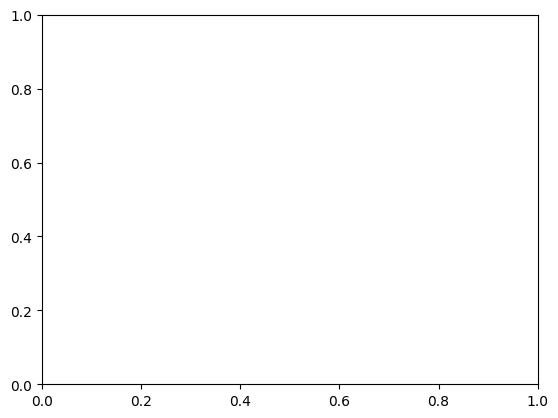

In [15]:
#Function calculating the SMA 
# Load historical price data into a DataFrame

df = quandl.get('BSE/SENSEX', start_date='2009-10-05', end_date='2019-10-05')

# Define the period and standard deviation multiplier
period = 20  # 20 days is apparently a medium-term indicator.
std_multiplier = 2  # Multiplier for standard deviation

# Calculate the rolling mean (middle band) and rolling standard deviation

#calculates the rolling mean of the closing price by 
# creating a rolling window of 'period'length and calculating the mean value within each window.
df['Middle Band'] = df['Close'].rolling(window=period).mean()


df['Upper Band'] = df['Middle Band'] + (df['Close'].rolling(window=period).std() * std_multiplier)
df['Lower Band'] = df['Middle Band'] - (df['Close'].rolling(window=period).std() * std_multiplier)

plt.plot(df.index, df['Middle Band'], marker='o', linestyle='-')
plt.xlabel("Date")
plt.ylabel("Price/ Rupees")
plt.show()

In [ ]:
# Generate buy and sell signals
df['Signal'] = 0  # Initialize signal column

# Buy signal: Price crosses below the lower Bollinger Band
df.loc[df['Close'] < df['Lower Band'], 'Signal'] = 1

# Sell signal: Price crosses above the upper Bollinger Band
df.loc[df['Close'] > df['Upper Band'], 'Signal'] = -1


In [ ]:
# Plot Bollinger Bands and trading signals
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(df['Close'], label='Price', alpha=0.5)
plt.plot(df['Middle Band'], label='Middle Band', linestyle='--')
plt.plot(df['Upper Band'], label='Upper Band', linestyle='--')
plt.plot(df['Lower Band'], label='Lower Band', linestyle='--')

# Plot buy signals as green arrows
plt.scatter(df.index[df['Signal'] == 1], df['Close'][df['Signal'] == 1], marker='^', color='g', label='Buy Signal', alpha=1)

# Plot sell signals as red arrows
plt.scatter(df.index[df['Signal'] == -1], df['Close'][df['Signal'] == -1], marker='v', color='r', label='Sell Signal', alpha=1)

plt.title('Bollinger Bands Trading Strategy')
plt.legend()
plt.show()

In [ ]:
#Test it on the other chuck of time period 

In [ ]:
#Performance measurement